In [25]:
import os
import gc
import torch
import psutil
import GPUtil
import mlflow
import tempfile
import numpy as np
import pandas as pd
import mlflow.pytorch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, classification_report

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable MLflow autologging for PyTorch
mlflow.pytorch.autolog()
mlflow.set_tracking_uri(uri="file:///C:/Users/jcwin/OneDrive - University of Southampton/_Southampton/2024-25/Star-Classifier/mlflow")
mlflow.set_experiment("Fusion_Gaia_LAMOST")

2024/10/23 11:15:21 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.4.1, but the installed version is 2.4.1+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
2024/10/23 11:15:21 INFO mlflow.tracking.fluent: Experiment with name 'Fusion_Gaia_LAMOST' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///C:/Users/jcwin/OneDrive - University of '
 'Southampton/_Southampton/2024-25/Star-Classifier/mlflow/918667260302729975'), creation_time=1729678521924, experiment_id='918667260302729975', last_update_time=1729678521924, lifecycle_stage='active', name='Fusion_Gaia_LAMOST', tags={}>

In [3]:
# check cuda
print("Device: ", device)

Device:  cuda


In [2]:
class ConvNetFusion(nn.Module):
    def __init__(self, input_shape, num_classes, gaia_input_size, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                 kernel_size=9,
                 dense_units=[256, 256, 256, 128, 128, 128, 64, 64, 64],
                 dropout_rate=0.2, 
                 gaia_fusion_units=512,
                 padding='same'):
        super(ConvNetFusion, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        in_channels = 1  # Since it's a 1D input
        
        # Add convolutional layers
        for filters in num_filters:
            conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv_layer)
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2))
            self.dropout = nn.Dropout(dropout_rate)
            in_channels = filters
        
        # Flatten the output
        self.flatten = nn.Flatten()
        final_seq_len = input_shape[0] // (2 ** len(num_filters)) * num_filters[-1]
        print("Size of the flattened output:", final_seq_len)

        # Add Gaia features to the input
        self.gaia_input_layer = nn.Linear(gaia_input_size, gaia_fusion_units)

        # Add dense layers
        dense_input_units = final_seq_len + gaia_fusion_units  # Add Gaia features to the dense input
        print("Dense input units:", dense_input_units)
        print("Final sequence length:", final_seq_len)
        print("Number of filters:", num_filters[-1])
        self.dense_layers = nn.ModuleList()
        for units in dense_units:
            self.dense_layers.append(nn.Linear(dense_input_units, units))
            dense_input_units = units
        
        # Output layer
        self.output_layer = nn.Linear(dense_input_units, num_classes)

    
    
    def forward(self, x_conv, x_gaia):
        # Pass through convolutional layers
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            x_conv = pool_layer(torch.relu(conv_layer(x_conv)))
            x_conv = self.dropout(x_conv)
        # Flatten the conv output
        x_conv = self.flatten(x_conv)

        # Connect Gaia features to a separate dense layer and connect after to the main network
        x_gaia = torch.relu(self.gaia_input_layer(x_gaia))

        # Concatenate Gaia features
        x = torch.cat((x_conv, x_gaia), dim=1)
        
        # Pass through dense layers
        for dense_layer in self.dense_layers:
            x = torch.relu(dense_layer(x))
            x = self.dropout(x)
        
        # Output layer
        x = self.output_layer(x)
        return torch.softmax(x, dim=1)

# Create Datasets
class BalancedDatasetFusion(Dataset):
    def __init__(self, X_conv, X_gaia, y, limit_per_label=1600):
        self.X_conv = X_conv
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X_conv[index], self.X_gaia[index], self.y[index]

# Define a function to train the mod

def train_model(model, train_loader, val_loader, test_loader, num_epochs=200, lr=1e-4, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    early_stopping_counter = 0
    best_test_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None  # Variable to store the best model state

    for epoch in range(num_epochs):
        # Re-sample the training dataset at the start of each epoch
        train_loader.dataset.re_sample()
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        # Training loop
        for X_conv, X_gaia, y in train_loader:
            X_conv, X_gaia, y = X_conv.to(device), X_gaia.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X_conv, X_gaia)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_conv.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y).sum().item()
            total_train += y.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation loop
        model.eval()
        val_loss, correct_val, total_val, test_loss, correct_test, total_test = 0, 0, 0, 0, 0, 0

        with torch.no_grad():
            for X_conv, X_gaia, y in val_loader:
                X_conv, X_gaia, y = X_conv.to(device), X_gaia.to(device), y.to(device)
                outputs = model(X_conv, X_gaia)
                loss = criterion(outputs, y)
                val_loss += loss.item() * X_conv.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y).sum().item()
                total_val += y.size(0)
        
        # Test loop
        with torch.no_grad():
            for X_conv, X_gaia, y in test_loader:
                X_conv, X_gaia, y = X_conv.to(device), X_gaia.to(device), y.to(device)
                outputs = model(X_conv, X_gaia)
                loss = criterion(outputs, y)
                test_loss += loss.item() * X_conv.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == y).sum().item()
                total_test += y.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val
        test_loss /= len(test_loader.dataset)
        test_acc = correct_test / total_test

        # Log metrics for MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test_acc", test_acc, step=epoch)

        # Early stopping and model saving
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict()  # Save the model state
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Load the best model weights before returning
    model.load_state_dict(best_model_state)
    return model
def print_confusion_matrix(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_conv, X_gaia, y in val_loader:
            # Move inputs and labels to the same device as the model
            X_conv, X_gaia, y = X_conv.to(device), X_gaia.to(device), y.to(device)

            outputs = model(X_conv, X_gaia)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and labels in CPU for further processing
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate and print additional metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")

    # Print classification report for each class
    class_names = ['Star', 'Binary Star', 'Galaxy', 'AGN']
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Log confusion matrix
    temp_file_path = save_confusion_matrix_to_file(cm)
    mlflow.log_artifact(temp_file_path, artifact_path="confusion_matrix")
    os.remove(temp_file_path)  # Clean up the temporary file

def save_confusion_matrix_to_file(cm):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import tempfile

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    xticklabels = ['Star', 'Binary Star', 'Galaxy', 'AGN']
    yticklabels = ['Star', 'Binary Star', 'Galaxy', 'AGN']
    
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=xticklabels, rotation=45)
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=yticklabels, rotation=0)

    # Save the figure to a temporary file
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    plt.savefig(temp_file.name, format='png')
    temp_file.close()
    
    return temp_file.name



In [3]:
if __name__ == "__main__":
        # Load and preprocess data
        X = pd.read_pickle("Pickles/fusionv0/train.pkl")
        gaia_features = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
        "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
        "phot_bp_mean_flux_error", "phot_rp_mean_flux_error"]

        # Extract Gaia and LASMOST data
        X_gaia = X[gaia_features].values
        X_conv = X.drop(gaia_features + ["label"], axis=1).values
        y = X["label"]

        # Mapping labels to integers
        label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
        y = y.map(label_mapping).values

        # Read test data
        X_test = pd.read_pickle("Pickles/fusionv0/test.pkl")
        X_test_gaia = X_test[gaia_features].values
        X_test_conv = X_test.drop(gaia_features + ["label"], axis=1).values
        y_test = X_test["label"]
        y_test = y_test.map(label_mapping).values


        # Split data into train and validation
        X_train_conv, X_val_conv, X_train_gaia, X_val_gaia, y_train, y_val = train_test_split(X_conv, X_gaia, y, test_size=0.2, random_state=42)

        # Convert to PyTorch tensors
        X_train_conv = torch.tensor(X_train_conv, dtype=torch.float32).unsqueeze(1)
        X_val_conv = torch.tensor(X_val_conv, dtype=torch.float32).unsqueeze(1)
        X_train_gaia = torch.tensor(X_train_gaia, dtype=torch.float32)
        X_val_gaia = torch.tensor(X_val_gaia, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        y_val = torch.tensor(y_val, dtype=torch.long)
        X_test_conv = torch.tensor(X_test_conv, dtype=torch.float32).unsqueeze(1)
        X_test_gaia = torch.tensor(X_test_gaia, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.long)

        # Create DataLoaders
        train_dataset = BalancedDatasetFusion(X_train_conv, X_train_gaia, y_train)
        val_dataset = BalancedDatasetFusion(X_val_conv, X_val_gaia, y_val)
        test_dataset = BalancedDatasetFusion(X_test_conv, X_test_gaia, y_test)

        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# BB

In [19]:
# Define the Spectra Branch as a separate module
class SpectraBranch(nn.Module):
    def __init__(self, input_shape, num_classes, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                 kernel_size=9,
                 dropout_rate=0.2, padding='same'):
        super(SpectraBranch, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        in_channels = 1  # Since it's a 1D input
        
        # Add convolutional layers
        for filters in num_filters:
            conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv_layer)
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2))
            in_channels = filters
        
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            x = pool_layer(torch.relu(conv_layer(x)))
            x = self.dropout(x)
        x = self.flatten(x)
        return x

# implementing none as an option for the gaia branch
class GaiaBranch(nn.Module):
    def __init__(self, gaia_input_size, gaia_fusion_units):
        super(GaiaBranch, self).__init__()
        self.gaia_fusion_units = gaia_fusion_units
        if gaia_fusion_units is not None:
            self.fc = nn.Linear(gaia_input_size, gaia_fusion_units)

    def forward(self, x):
        if self.gaia_fusion_units is None:
            return x
        else:
            return torch.relu(self.fc(x))


# Fusion Model that combines both branches
class ConvNetFusion(nn.Module):
    def __init__(self, input_shape, num_classes, gaia_input_size, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128],  # More filters for SpectraBranch
                 kernel_size=9,
                 dense_units=[256, 128, 64, 32],
                 dropout_rate=0.2, 
                 gaia_fusion_units=256):
        super(ConvNetFusion, self).__init__()

        # Instantiate the two branches
        self.spectra_branch = SpectraBranch(input_shape, num_classes, num_filters, kernel_size, dropout_rate)
        self.gaia_branch = GaiaBranch(gaia_input_size, gaia_fusion_units)

        # Fused input size
        if gaia_fusion_units is None:
            fused_input_size = gaia_input_size + num_filters[-1] * (input_shape[0] // (2 ** len(num_filters)))
        else:
            fused_input_size = gaia_fusion_units + num_filters[-1] * (input_shape[0] // (2 ** len(num_filters)))
        
        # Fully connected layers after fusion
        for i, units in enumerate(dense_units):
            if i == 0:
                self.dense_layers = nn.Sequential(
                    nn.Linear(fused_input_size, units),
                    nn.ReLU()
                    #nn.Dropout(0)
                )
            else:
                self.dense_layers.add_module(f"dense_{i}", nn.Linear(dense_units[i-1], units))
                self.dense_layers.add_module(f"relu_{i}", nn.ReLU())
                self.dense_layers.add_module(f"dropout_{i}", nn.Dropout(dropout_rate))

        # Output layer
        self.output_layer = nn.Linear(dense_units[-1], num_classes)

    def forward(self, x_conv, x_gaia):
        # Spectra branch forward pass
        x_conv = self.spectra_branch(x_conv)
        
        # Gaia branch forward pass
        x_gaia = self.gaia_branch(x_gaia)
        
        # Concatenate the two branches
        x_fused = torch.cat((x_conv, x_gaia), dim=1)

        # Pass through dense layers
        x = self.dense_layers(x_fused)

        # Output layer
        x = self.output_layer(x)
        
        return torch.softmax(x, dim=1)

In [20]:
# Initialize model
gaia_input_size = X_train_gaia.shape[1]
print(f"Gaia input size: {gaia_input_size}")
filters = [128, 128, 128, 256, 256, 256, 512, 512, 512, 1024, 1024] 
filters = [32, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512]
dense=[2048, 2048, 2048, 512, 128, 64]
dense = [1024, 1024, 1024, 256, 64]

model = ConvNetFusion(input_shape=(3748,), num_classes=4, gaia_input_size=gaia_input_size, 
                      num_filters=filters, kernel_size=9, dense_units=dense, dropout_rate=0.2, gaia_fusion_units=None) # trying to supress gaia dependence
# Save the model
torch.save(model, "Models/toyv0.pth")
# Print model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model = model.to(device)

Gaia input size: 17
ConvNetFusion(
  (spectra_branch): SpectraBranch(
    (conv_layers): ModuleList(
      (0): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
      (3): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (4-5): 2 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (6): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (7-8): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (9): Conv1d(256, 512, kernel_size=(9,), stride=(1,), padding=(4,))
      (10): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    )
    (pool_layers): ModuleList(
      (0-10): 11 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (

# Bunda bebe

2024/10/23 11:15:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/200], Train Loss: 0.8823, Train Acc: 0.8593, Val Loss: 0.9018, Val Acc: 0.8411, Test Loss: 0.9072, Test Acc: 0.8342
Epoch [2/200], Train Loss: 0.8767, Train Acc: 0.8672, Val Loss: 0.9043, Val Acc: 0.8372, Test Loss: 0.9073, Test Acc: 0.8337
Epoch [3/200], Train Loss: 0.8840, Train Acc: 0.8577, Val Loss: 0.9018, Val Acc: 0.8425, Test Loss: 0.9043, Test Acc: 0.8379
Epoch [4/200], Train Loss: 0.8855, Train Acc: 0.8572, Val Loss: 0.8999, Val Acc: 0.8425, Test Loss: 0.9052, Test Acc: 0.8358
Epoch [5/200], Train Loss: 0.8786, Train Acc: 0.8637, Val Loss: 0.9031, Val Acc: 0.8395, Test Loss: 0.9058, Test Acc: 0.8356
Epoch [6/200], Train Loss: 0.8829, Train Acc: 0.8596, Val Loss: 0.9058, Val Acc: 0.8345, Test Loss: 0.9098, Test Acc: 0.8310
Epoch [7/200], Train Loss: 0.8833, Train Acc: 0.8611, Val Loss: 0.9107, Val Acc: 0.8298, Test Loss: 0.9144, Test Acc: 0.8281
Epoch [8/200], Train Loss: 0.8905, Train Acc: 0.8524, Val Loss: 0.9014, Val Acc: 0.8403, Test Loss: 0.9034, Test Acc: 0.8375


2024/10/23 11:24:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/23 11:24:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/23 11:24:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/23 11:24:16 INFO mlflow.system_metrics.syste

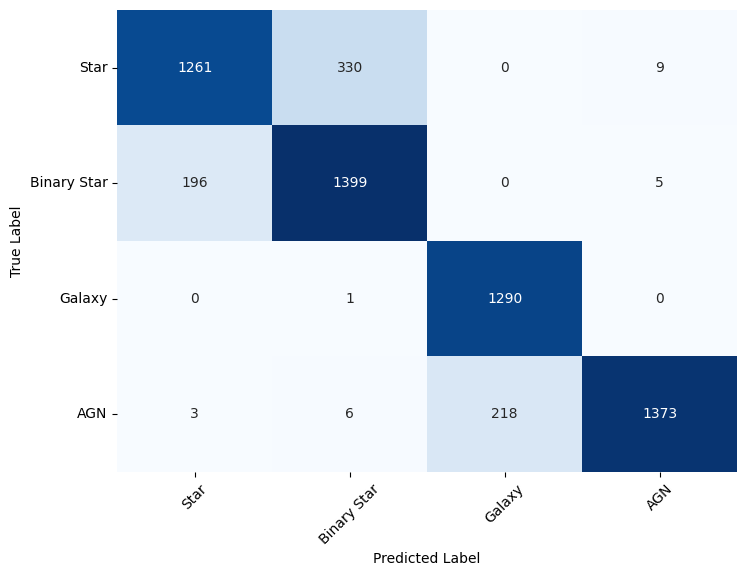

In [26]:
# Training parameters
num_epochs = 200
lr = 1e-4
patience = 50
batch_size = 256

mlflow.end_run()
# Start an MLflow run
with mlflow.start_run(log_system_metrics=True):
    # Log parameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("lr", lr)
    mlflow.log_param("patience", patience)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_filters", filters)
    mlflow.log_param("dense_units", dense)
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("kernel_size", 9)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, test_loader, num_epochs=num_epochs, lr=lr, patience=patience)

    # Evaluate the model
    print_confusion_matrix(trained_model, train_loader)
    # Save the model in MLflow
    mlflow.pytorch.log_model(trained_model, "model")

Confusion Matrix:
[[1267  329    1    3]
 [ 202 1391    4    3]
 [   0    0  372    4]
 [  12    2  184 1402]]
Accuracy: 0.8562596599690881
Recall: 0.8562596599690881
F1 Score: 0.8585613520149927
Precision: 0.8692523683967281

Classification Report:
              precision    recall  f1-score   support

        Star       0.86      0.79      0.82      1600
 Binary Star       0.81      0.87      0.84      1600
      Galaxy       0.66      0.99      0.79       376
         AGN       0.99      0.88      0.93      1600

    accuracy                           0.86      5176
   macro avg       0.83      0.88      0.85      5176
weighted avg       0.87      0.86      0.86      5176



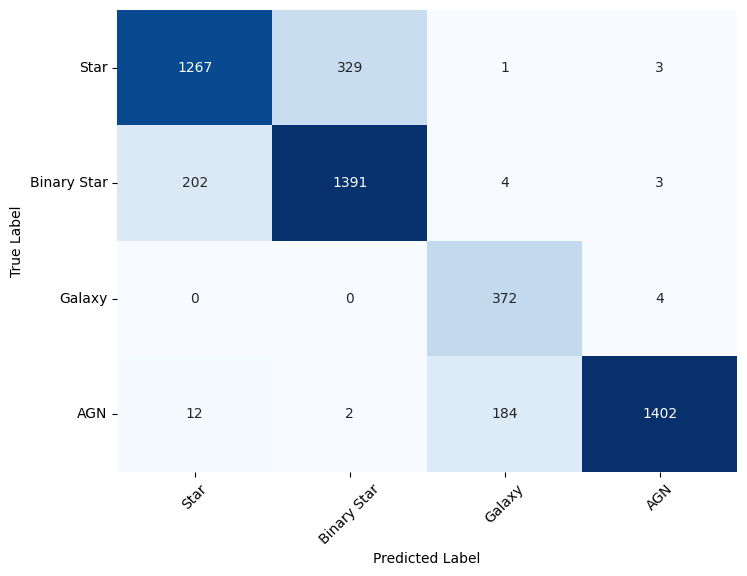

In [7]:
# Example usage
print_confusion_matrix(model, test_loader)


# BB plus size

In [4]:
# Initialize model
gaia_input_size = X_train_gaia.shape[1]
print(f"Gaia input size: {gaia_input_size}")
filters = [256, 256, 256, 256, 512, 512, 512, 512, 1024, 1024, 1024] 
dense=[2048, 2048, 2048, 2048, 512, 128, 64]

model = ConvNetFusion(input_shape=(3748,), num_classes=4, gaia_input_size=gaia_input_size, 
                      num_filters=filters, kernel_size=9, dense_units=dense, dropout_rate=0.2, gaia_fusion_units=filters[-1])
# Save the model
torch.save(model, "Models/toyv0.pth")
# Print model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model = model.to(device)

Gaia input size: 17
Size of the flattened output: 1024
Dense input units: 2048
Final sequence length: 1024
Number of filters: 1024
ConvNetFusion(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (1-3): 3 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): Conv1d(256, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    (5-7): 3 x Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    (8): Conv1d(512, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
    (9-10): 2 x Conv1d(1024, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (pool_layers): ModuleList(
    (0-10): 11 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gaia_input_layer): Linear(in_features=17, out_features=1024, bias=True)
  (dense_layers): ModuleList(
    (0-3): 4 x Linear(in_features=2048, out_features=204

In [5]:
# Training parameters
num_epochs = 200
lr = 1e-4
patience = 20
batch_size = 256

mlflow.end_run()
# Start an MLflow run
with mlflow.start_run(log_system_metrics=True):
    # Log parameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("lr", lr)
    mlflow.log_param("patience", patience)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_filters", filters)
    mlflow.log_param("dense_units", dense)
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("kernel_size", 9)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, test_loader, num_epochs=num_epochs, lr=lr, patience=patience)

    # Evaluate the model
    print_confusion_matrix(trained_model, train_loader)
    # Save the model in MLflow
    mlflow.pytorch.log_model(trained_model, "model")

2024/10/22 22:46:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/200], Train Loss: 1.3822, Train Acc: 0.3538, Val Loss: 1.3701, Val Acc: 0.3484, Test Loss: 1.3693, Test Acc: 0.3595
Epoch [2/200], Train Loss: 1.2535, Train Acc: 0.5439, Val Loss: 1.1982, Val Acc: 0.6006, Test Loss: 1.1920, Test Acc: 0.6124
Epoch [3/200], Train Loss: 1.0880, Train Acc: 0.6492, Val Loss: 1.1154, Val Acc: 0.6002, Test Loss: 1.1076, Test Acc: 0.6107
Epoch [4/200], Train Loss: 1.0590, Train Acc: 0.6505, Val Loss: 1.0928, Val Acc: 0.6125, Test Loss: 1.0859, Test Acc: 0.6180
Epoch [5/200], Train Loss: 1.0384, Train Acc: 0.6835, Val Loss: 1.0966, Val Acc: 0.6066, Test Loss: 1.0909, Test Acc: 0.6155
Epoch [6/200], Train Loss: 1.0326, Train Acc: 0.6789, Val Loss: 1.0872, Val Acc: 0.6127, Test Loss: 1.0818, Test Acc: 0.6188
Epoch [7/200], Train Loss: 1.0362, Train Acc: 0.6789, Val Loss: 1.0779, Val Acc: 0.6220, Test Loss: 1.0729, Test Acc: 0.6244
Epoch [8/200], Train Loss: 1.0330, Train Acc: 0.6820, Val Loss: 1.0767, Val Acc: 0.6224, Test Loss: 1.0714, Test Acc: 0.6264


2024/10/23 06:36:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/23 06:36:56 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping triggered.


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [6]:
# Evaluate the model
print_confusion_matrix(trained_model, train_loader)
# Save the model in MLflow
mlflow.pytorch.log_model(trained_model, "model")

ValueError: too many values to unpack (expected 2)

# end of bbps

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


Confusion Matrix:
[[1328  257    0   15]
 [ 341 1254    1    4]
 [   0    1  371    4]
 [   4   10  218 1368]]
Accuracy: 0.8348145285935085
Recall: 0.8348145285935085
F1 Score: 0.8377343457762585
Precision: 0.849748328224245

Classification Report:
              precision    recall  f1-score   support

        Star       0.79      0.83      0.81      1600
 Binary Star       0.82      0.78      0.80      1600
      Galaxy       0.63      0.99      0.77       376
         AGN       0.98      0.85      0.91      1600

    accuracy                           0.83      5176
   macro avg       0.81      0.86      0.82      5176
weighted avg       0.85      0.83      0.84      5176



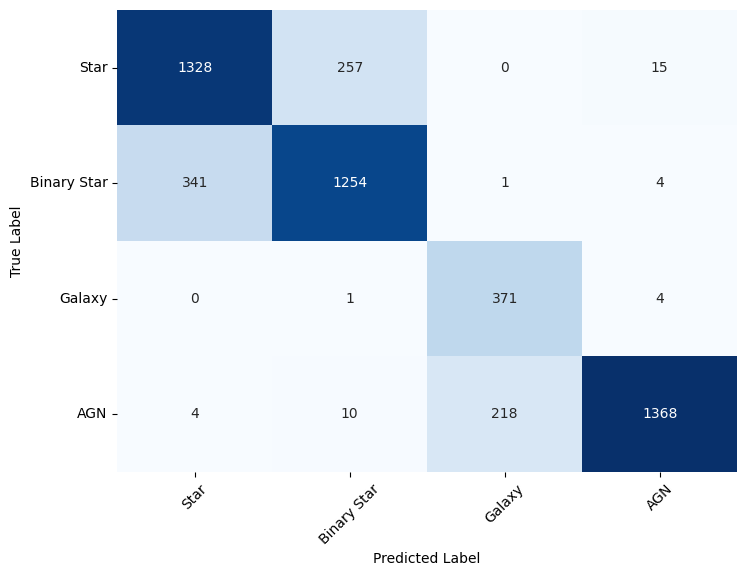

In [8]:
# Example usage
print_confusion_matrix(trained_model, test_loader)


2024/10/22 12:29:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/10/22 12:29:52 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:30:02 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:30:23 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:30:33 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [1/200], Train Loss: 0.8836, Train Acc: 0.8590, Val Loss: 0.9054, Val Acc: 0.8364, Test Loss: 0.8977, Test Acc: 0.8443


2024/10/22 12:30:53 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:31:03 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [2/200], Train Loss: 0.8810, Train Acc: 0.8611, Val Loss: 0.9051, Val Acc: 0.8372, Test Loss: 0.8970, Test Acc: 0.8464


2024/10/22 12:31:23 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:31:33 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:31:54 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [3/200], Train Loss: 0.8788, Train Acc: 0.8641, Val Loss: 0.9045, Val Acc: 0.8374, Test Loss: 0.8972, Test Acc: 0.8464


2024/10/22 12:32:04 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:32:24 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:32:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [4/200], Train Loss: 0.8845, Train Acc: 0.8565, Val Loss: 0.9037, Val Acc: 0.8391, Test Loss: 0.8963, Test Acc: 0.8466


2024/10/22 12:32:54 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:33:04 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:33:24 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [5/200], Train Loss: 0.8797, Train Acc: 0.8626, Val Loss: 0.9033, Val Acc: 0.8378, Test Loss: 0.8953, Test Acc: 0.8474


2024/10/22 12:33:35 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:33:55 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:34:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [6/200], Train Loss: 0.8810, Train Acc: 0.8619, Val Loss: 0.9039, Val Acc: 0.8376, Test Loss: 0.8957, Test Acc: 0.8468


2024/10/22 12:34:25 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:34:35 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [7/200], Train Loss: 0.8769, Train Acc: 0.8650, Val Loss: 0.9045, Val Acc: 0.8384, Test Loss: 0.8975, Test Acc: 0.8454


2024/10/22 12:34:55 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:35:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:35:26 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [8/200], Train Loss: 0.8770, Train Acc: 0.8665, Val Loss: 0.9044, Val Acc: 0.8388, Test Loss: 0.8971, Test Acc: 0.8447


2024/10/22 12:35:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:35:56 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:36:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [9/200], Train Loss: 0.8758, Train Acc: 0.8670, Val Loss: 0.9034, Val Acc: 0.8386, Test Loss: 0.8948, Test Acc: 0.8480


2024/10/22 12:36:26 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:36:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [10/200], Train Loss: 0.8757, Train Acc: 0.8673, Val Loss: 0.9035, Val Acc: 0.8386, Test Loss: 0.8944, Test Acc: 0.8489


2024/10/22 12:36:57 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:37:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:37:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [11/200], Train Loss: 0.8769, Train Acc: 0.8644, Val Loss: 0.9040, Val Acc: 0.8382, Test Loss: 0.8951, Test Acc: 0.8468


2024/10/22 12:37:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:37:58 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:38:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [12/200], Train Loss: 0.8809, Train Acc: 0.8619, Val Loss: 0.9045, Val Acc: 0.8376, Test Loss: 0.8965, Test Acc: 0.8447


2024/10/22 12:38:28 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:38:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:38:58 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [13/200], Train Loss: 0.8793, Train Acc: 0.8626, Val Loss: 0.9030, Val Acc: 0.8393, Test Loss: 0.8958, Test Acc: 0.8454


2024/10/22 12:39:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:39:29 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:39:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [14/200], Train Loss: 0.8734, Train Acc: 0.8688, Val Loss: 0.9024, Val Acc: 0.8401, Test Loss: 0.8953, Test Acc: 0.8452


2024/10/22 12:39:59 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:40:09 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:40:29 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [15/200], Train Loss: 0.8756, Train Acc: 0.8664, Val Loss: 0.9015, Val Acc: 0.8399, Test Loss: 0.8948, Test Acc: 0.8470


2024/10/22 12:40:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:41:00 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:41:10 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [16/200], Train Loss: 0.8752, Train Acc: 0.8675, Val Loss: 0.9017, Val Acc: 0.8399, Test Loss: 0.8952, Test Acc: 0.8478


2024/10/22 12:41:30 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:41:40 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:42:00 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [17/200], Train Loss: 0.8743, Train Acc: 0.8680, Val Loss: 0.9019, Val Acc: 0.8391, Test Loss: 0.8937, Test Acc: 0.8483


2024/10/22 12:42:10 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:42:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:42:41 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [18/200], Train Loss: 0.8785, Train Acc: 0.8655, Val Loss: 0.9016, Val Acc: 0.8397, Test Loss: 0.8944, Test Acc: 0.8487


2024/10/22 12:43:01 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:43:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:43:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [19/200], Train Loss: 0.8729, Train Acc: 0.8695, Val Loss: 0.9017, Val Acc: 0.8399, Test Loss: 0.8940, Test Acc: 0.8483


2024/10/22 12:43:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:44:02 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:44:12 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [20/200], Train Loss: 0.8773, Train Acc: 0.8639, Val Loss: 0.9018, Val Acc: 0.8397, Test Loss: 0.8936, Test Acc: 0.8489


2024/10/22 12:44:32 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:44:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:45:02 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:45:12 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [21/200], Train Loss: 0.8723, Train Acc: 0.8695, Val Loss: 0.9016, Val Acc: 0.8415, Test Loss: 0.8934, Test Acc: 0.8487


2024/10/22 12:45:33 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:45:43 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:46:03 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [22/200], Train Loss: 0.8748, Train Acc: 0.8682, Val Loss: 0.9015, Val Acc: 0.8397, Test Loss: 0.8925, Test Acc: 0.8505


2024/10/22 12:46:13 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:46:33 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:46:43 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [23/200], Train Loss: 0.8726, Train Acc: 0.8688, Val Loss: 0.9011, Val Acc: 0.8401, Test Loss: 0.8925, Test Acc: 0.8503


2024/10/22 12:47:03 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:47:14 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:47:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:47:44 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [24/200], Train Loss: 0.8716, Train Acc: 0.8703, Val Loss: 0.9010, Val Acc: 0.8401, Test Loss: 0.8924, Test Acc: 0.8489


2024/10/22 12:48:04 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:48:14 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:48:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [25/200], Train Loss: 0.8830, Train Acc: 0.8585, Val Loss: 0.9014, Val Acc: 0.8401, Test Loss: 0.8926, Test Acc: 0.8497


2024/10/22 12:48:44 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:49:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:49:15 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:49:35 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [26/200], Train Loss: 0.8769, Train Acc: 0.8665, Val Loss: 0.9005, Val Acc: 0.8413, Test Loss: 0.8928, Test Acc: 0.8483


2024/10/22 12:49:45 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:50:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:50:15 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [27/200], Train Loss: 0.8788, Train Acc: 0.8641, Val Loss: 0.9001, Val Acc: 0.8419, Test Loss: 0.8927, Test Acc: 0.8491


2024/10/22 12:50:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:50:46 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:51:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:51:16 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [28/200], Train Loss: 0.8713, Train Acc: 0.8719, Val Loss: 0.9000, Val Acc: 0.8440, Test Loss: 0.8933, Test Acc: 0.8474


2024/10/22 12:51:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:51:46 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:52:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:52:17 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [29/200], Train Loss: 0.8780, Train Acc: 0.8642, Val Loss: 0.9000, Val Acc: 0.8434, Test Loss: 0.8934, Test Acc: 0.8480


2024/10/22 12:52:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:52:47 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:53:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:53:17 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [30/200], Train Loss: 0.8798, Train Acc: 0.8619, Val Loss: 0.9004, Val Acc: 0.8415, Test Loss: 0.8922, Test Acc: 0.8487


2024/10/22 12:53:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:53:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:54:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:54:18 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [31/200], Train Loss: 0.8782, Train Acc: 0.8636, Val Loss: 0.9009, Val Acc: 0.8403, Test Loss: 0.8913, Test Acc: 0.8505


2024/10/22 12:54:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:54:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:55:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:55:19 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [32/200], Train Loss: 0.8753, Train Acc: 0.8680, Val Loss: 0.9001, Val Acc: 0.8413, Test Loss: 0.8915, Test Acc: 0.8503


2024/10/22 12:55:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:55:49 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:56:09 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:56:19 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [33/200], Train Loss: 0.8737, Train Acc: 0.8678, Val Loss: 0.9009, Val Acc: 0.8401, Test Loss: 0.8918, Test Acc: 0.8495


2024/10/22 12:56:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:56:50 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:57:10 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:57:20 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [34/200], Train Loss: 0.8748, Train Acc: 0.8682, Val Loss: 0.9008, Val Acc: 0.8411, Test Loss: 0.8920, Test Acc: 0.8499


2024/10/22 12:57:40 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:57:50 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:58:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:58:21 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [35/200], Train Loss: 0.8672, Train Acc: 0.8749, Val Loss: 0.8996, Val Acc: 0.8421, Test Loss: 0.8922, Test Acc: 0.8487


2024/10/22 12:58:41 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:58:51 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:59:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:59:21 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [36/200], Train Loss: 0.8745, Train Acc: 0.8672, Val Loss: 0.9008, Val Acc: 0.8419, Test Loss: 0.8929, Test Acc: 0.8489


2024/10/22 12:59:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 12:59:52 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:00:12 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [37/200], Train Loss: 0.8775, Train Acc: 0.8642, Val Loss: 0.9019, Val Acc: 0.8403, Test Loss: 0.8933, Test Acc: 0.8503


2024/10/22 13:00:22 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:00:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:00:53 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:01:13 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [38/200], Train Loss: 0.8786, Train Acc: 0.8634, Val Loss: 0.9029, Val Acc: 0.8395, Test Loss: 0.8935, Test Acc: 0.8481


2024/10/22 13:01:23 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:01:43 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:01:53 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [39/200], Train Loss: 0.8773, Train Acc: 0.8657, Val Loss: 0.9037, Val Acc: 0.8386, Test Loss: 0.8927, Test Acc: 0.8487


2024/10/22 13:02:13 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:02:24 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:02:44 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:02:54 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [40/200], Train Loss: 0.8841, Train Acc: 0.8591, Val Loss: 0.9036, Val Acc: 0.8382, Test Loss: 0.8927, Test Acc: 0.8478


2024/10/22 13:03:14 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:03:24 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:03:44 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:03:54 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [41/200], Train Loss: 0.8659, Train Acc: 0.8777, Val Loss: 0.9018, Val Acc: 0.8417, Test Loss: 0.8933, Test Acc: 0.8464


2024/10/22 13:04:15 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:04:25 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:04:45 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [42/200], Train Loss: 0.8735, Train Acc: 0.8690, Val Loss: 0.9017, Val Acc: 0.8415, Test Loss: 0.8936, Test Acc: 0.8462


2024/10/22 13:05:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:05:16 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:05:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:05:46 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [43/200], Train Loss: 0.8758, Train Acc: 0.8660, Val Loss: 0.9018, Val Acc: 0.8425, Test Loss: 0.8938, Test Acc: 0.8458


2024/10/22 13:06:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:06:16 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:06:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:06:47 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [44/200], Train Loss: 0.8793, Train Acc: 0.8641, Val Loss: 0.9024, Val Acc: 0.8407, Test Loss: 0.8927, Test Acc: 0.8485


2024/10/22 13:07:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:07:17 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:07:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [45/200], Train Loss: 0.8680, Train Acc: 0.8754, Val Loss: 0.9025, Val Acc: 0.8407, Test Loss: 0.8922, Test Acc: 0.8487


2024/10/22 13:07:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:08:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:08:18 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [46/200], Train Loss: 0.8775, Train Acc: 0.8664, Val Loss: 0.9019, Val Acc: 0.8413, Test Loss: 0.8934, Test Acc: 0.8466


2024/10/22 13:08:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:08:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:09:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:09:18 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [47/200], Train Loss: 0.8778, Train Acc: 0.8639, Val Loss: 0.9021, Val Acc: 0.8405, Test Loss: 0.8931, Test Acc: 0.8481


2024/10/22 13:09:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:09:49 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:10:09 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [48/200], Train Loss: 0.8781, Train Acc: 0.8647, Val Loss: 0.9010, Val Acc: 0.8425, Test Loss: 0.8919, Test Acc: 0.8497


2024/10/22 13:10:30 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:10:40 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:11:00 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [49/200], Train Loss: 0.8773, Train Acc: 0.8650, Val Loss: 0.9008, Val Acc: 0.8426, Test Loss: 0.8911, Test Acc: 0.8501


2024/10/22 13:11:10 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:11:30 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:11:41 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:12:01 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [50/200], Train Loss: 0.8722, Train Acc: 0.8701, Val Loss: 0.9000, Val Acc: 0.8430, Test Loss: 0.8908, Test Acc: 0.8522


2024/10/22 13:12:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:12:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:12:41 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [51/200], Train Loss: 0.8697, Train Acc: 0.8737, Val Loss: 0.9001, Val Acc: 0.8419, Test Loss: 0.8914, Test Acc: 0.8512


2024/10/22 13:13:01 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:13:12 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:13:32 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:13:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [52/200], Train Loss: 0.8711, Train Acc: 0.8718, Val Loss: 0.8995, Val Acc: 0.8428, Test Loss: 0.8919, Test Acc: 0.8518


2024/10/22 13:14:02 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:14:12 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:14:32 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [53/200], Train Loss: 0.8732, Train Acc: 0.8688, Val Loss: 0.9001, Val Acc: 0.8415, Test Loss: 0.8916, Test Acc: 0.8532


2024/10/22 13:14:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:15:03 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:15:13 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [54/200], Train Loss: 0.8693, Train Acc: 0.8731, Val Loss: 0.9004, Val Acc: 0.8417, Test Loss: 0.8911, Test Acc: 0.8534


2024/10/22 13:15:33 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:15:43 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:16:03 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:16:13 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [55/200], Train Loss: 0.8810, Train Acc: 0.8603, Val Loss: 0.9010, Val Acc: 0.8409, Test Loss: 0.8908, Test Acc: 0.8520


2024/10/22 13:16:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:16:44 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:17:04 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [56/200], Train Loss: 0.8746, Train Acc: 0.8685, Val Loss: 0.9009, Val Acc: 0.8411, Test Loss: 0.8912, Test Acc: 0.8530


2024/10/22 13:17:14 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:17:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:17:44 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [57/200], Train Loss: 0.8767, Train Acc: 0.8654, Val Loss: 0.9009, Val Acc: 0.8413, Test Loss: 0.8931, Test Acc: 0.8481


2024/10/22 13:18:04 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:18:25 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:18:35 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [58/200], Train Loss: 0.8783, Train Acc: 0.8646, Val Loss: 0.9012, Val Acc: 0.8419, Test Loss: 0.8928, Test Acc: 0.8489


2024/10/22 13:18:56 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:19:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:19:26 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [59/200], Train Loss: 0.8805, Train Acc: 0.8629, Val Loss: 0.9008, Val Acc: 0.8415, Test Loss: 0.8911, Test Acc: 0.8524


2024/10/22 13:19:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:19:56 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:20:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [60/200], Train Loss: 0.8754, Train Acc: 0.8675, Val Loss: 0.9002, Val Acc: 0.8425, Test Loss: 0.8911, Test Acc: 0.8526


2024/10/22 13:20:26 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:20:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:20:57 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:21:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [61/200], Train Loss: 0.8731, Train Acc: 0.8688, Val Loss: 0.9005, Val Acc: 0.8423, Test Loss: 0.8910, Test Acc: 0.8528


2024/10/22 13:21:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:21:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:21:57 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [62/200], Train Loss: 0.8754, Train Acc: 0.8678, Val Loss: 0.9005, Val Acc: 0.8413, Test Loss: 0.8916, Test Acc: 0.8505


2024/10/22 13:22:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:22:28 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:22:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [63/200], Train Loss: 0.8820, Train Acc: 0.8604, Val Loss: 0.9010, Val Acc: 0.8421, Test Loss: 0.8912, Test Acc: 0.8512


2024/10/22 13:22:58 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:23:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:23:28 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:23:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [64/200], Train Loss: 0.8704, Train Acc: 0.8719, Val Loss: 0.9007, Val Acc: 0.8421, Test Loss: 0.8923, Test Acc: 0.8501


2024/10/22 13:23:59 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:24:09 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:24:29 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [65/200], Train Loss: 0.8725, Train Acc: 0.8708, Val Loss: 0.9000, Val Acc: 0.8428, Test Loss: 0.8921, Test Acc: 0.8509


2024/10/22 13:24:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:24:59 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:25:09 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [66/200], Train Loss: 0.8717, Train Acc: 0.8716, Val Loss: 0.9006, Val Acc: 0.8421, Test Loss: 0.8920, Test Acc: 0.8518


2024/10/22 13:25:30 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:25:40 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:26:00 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:26:10 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [67/200], Train Loss: 0.8795, Train Acc: 0.8621, Val Loss: 0.9008, Val Acc: 0.8411, Test Loss: 0.8917, Test Acc: 0.8516


2024/10/22 13:26:30 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:26:40 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:27:01 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [68/200], Train Loss: 0.8722, Train Acc: 0.8696, Val Loss: 0.9001, Val Acc: 0.8415, Test Loss: 0.8917, Test Acc: 0.8524


2024/10/22 13:27:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:27:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:27:41 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [69/200], Train Loss: 0.8764, Train Acc: 0.8667, Val Loss: 0.9001, Val Acc: 0.8419, Test Loss: 0.8924, Test Acc: 0.8495


2024/10/22 13:28:01 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:28:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:28:32 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/22 13:28:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Early stopping triggered.
Confusion Matrix:
[[1270  302    1   27]
 [ 206 1381    2   11]
 [   1    0 1278   12]
 [  18    8  251 1323]]
Accuracy: 0.8622557872270563
Recall: 0.8622557872270563
F1 Score: 0.8617324609880271
Precision: 0.8676030389668692

Classification Report:
              precision    recall  f1-score   support

        Star       0.85      0.79      0.82      1600
 Binary Star       0.82      0.86      0.84      1600
      Galaxy       0.83      0.99      0.91      1291
         AGN       0.96      0.83      0.89      1600

    accuracy                           0.86      6091
   macro avg       0.87      0.87      0.86      6091
weighted avg       0.87      0.86      0.86      6091



2024/10/22 13:28:57 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/22 13:28:57 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


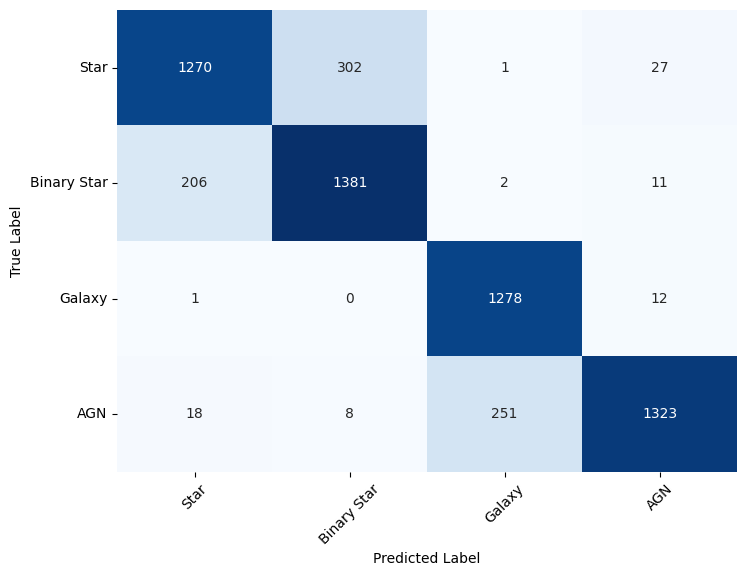

In [32]:
# Training parameters
num_epochs = 200
lr = 1e-4
patience = 20
batch_size = 512

mlflow.end_run()
# Start an MLflow run
with mlflow.start_run(log_system_metrics=True):
    # Log parameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("lr", lr)
    mlflow.log_param("patience", patience)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_filters", filters)
    mlflow.log_param("dense_units", dense)
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("kernel_size", 9)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, test_loader, num_epochs=num_epochs, lr=lr, patience=patience)


    # Save the model in MLflow
    #mlflow.pytorch.log_model(trained_model, "model")